# Reading Excel File Of Mosaic

In [2]:
import pandas as pd

# Load the Excel file
file_path = '/Users/yshokrollahi/Desktop/MD/Project3/dataset/IF/MOSAIC DSP Set 2 Initial Dataset_raw.xlsx'  # Replace with your file path
data = pd.read_excel(file_path)

# Extracting relevant columns for cases from MOS015S1 | 001 | Tumor to MOS025S1 | 006 | Tumor

# Identifying relevant columns
columns_of_interest = [col for col in data.columns if any(case in col for case in ["MOS0" + str(i).zfill(2) + "S1" for i in range(15, 30)]) and "| Tumor" in col and any(num in col for num in ["| " + str(i).zfill(3) + " |" for i in range(1, 7)])]

roi_data = data[columns_of_interest]

# Skip the first four rows which are metadata
roi_data = roi_data.iloc[4:]

# Convert the ROI data into a dictionary format for easier access
roi_dict = {}
for col in columns_of_interest:
    case_number = col.split("|")[0].strip()
    # Replace 'MOS0' with 'MSO' in the case number
    modified_case_number = case_number.replace('MOS0', 'MS0')
    if modified_case_number not in roi_dict:
        roi_dict[modified_case_number] = []
    roi_dict[modified_case_number].append(roi_data[col].tolist())

# Now `roi_dict` contains the ROI coordinates organized by case number


In [3]:
print(roi_dict['MS016S1'])

[[9732.7841796875, 13657.29296875], [17218.03515625, 12967.7392578125], [9066.126953125, 15840.1474609375], [5502.60400390625, 18122.96484375], [21603.474609375, 20135.986328125], [11863.0888671875, 10624.0654296875]]


In [37]:
from PIL import Image
import os

def extract_and_save_roi(image_folder, roi_dict, roi_size, save_folder):
    for image_name in roi_dict:
        # Adjust the image path to include the .png extension
        image_path = os.path.join(image_folder, image_name + '.png')  # Use .png as the file extension
        try:
            img = Image.open(image_path)
        except FileNotFoundError:
            print(f"Image {image_name} not found in {image_folder}.")
            continue

        for idx, (x_center, y_center) in enumerate(roi_dict[image_name]):
            # Calculate top-left and bottom-right coordinates of the ROI box
            left = int(x_center - roi_size[0] // 2)
            top = int(y_center - roi_size[1] // 2)
            right = int(x_center + roi_size[0] // 2)
            bottom = int(y_center + roi_size[1] // 2)
            print(roi_size[0])
            print(roi_size[1])
            print(left)
            print(top)
            print(right)
            print(bottom)
            print('****')
            # Extract the ROI and save
            roi = img.crop((left, top, right, bottom))
            roi.save(os.path.join(save_folder, f'{image_name}_roi_{idx}.png'))

# Example usage
image_folder = '/Users/yshokrollahi/Desktop/MD/Project3/dataset/IF/MS015S1'  # Path to your images folder
roi_dict = roi_dict  # Your dictionary of ROIs
roi_size = (826, 984)  # Size of the ROI box, adjust as needed
save_folder = '/Users/yshokrollahi/Desktop/MD/Project3/dataset/IF/MS015S1/extracted_rois'  # Replace with the path to your save folder

extract_and_save_roi(image_folder, roi_dict, roi_size, save_folder)


Image MS016S1 not found in /Users/yshokrollahi/Desktop/MD/Project3/dataset/IF/MS015S1.
Image MS018S1 not found in /Users/yshokrollahi/Desktop/MD/Project3/dataset/IF/MS015S1.
Image MS029S1 not found in /Users/yshokrollahi/Desktop/MD/Project3/dataset/IF/MS015S1.
Image MS020S1 not found in /Users/yshokrollahi/Desktop/MD/Project3/dataset/IF/MS015S1.
Image MS026S1 not found in /Users/yshokrollahi/Desktop/MD/Project3/dataset/IF/MS015S1.
Image MS022S1 not found in /Users/yshokrollahi/Desktop/MD/Project3/dataset/IF/MS015S1.
Image MS025S1 not found in /Users/yshokrollahi/Desktop/MD/Project3/dataset/IF/MS015S1.
Image MS023S1 not found in /Users/yshokrollahi/Desktop/MD/Project3/dataset/IF/MS015S1.
Image MS021S1 not found in /Users/yshokrollahi/Desktop/MD/Project3/dataset/IF/MS015S1.
Image MS028S1 not found in /Users/yshokrollahi/Desktop/MD/Project3/dataset/IF/MS015S1.
Image MS017S1 not found in /Users/yshokrollahi/Desktop/MD/Project3/dataset/IF/MS015S1.
Image MS019S1 not found in /Users/yshokroll

ROI at (349, 1061): Width = 169, Height = 197
ROI at (607, 954): Width = 166, Height = 199
ROI at (446, 741): Width = 166, Height = 197
ROI at (169, 597): Width = 167, Height = 197
ROI at (678, 388): Width = 169, Height = 198
ROI at (305, 355): Width = 166, Height = 198


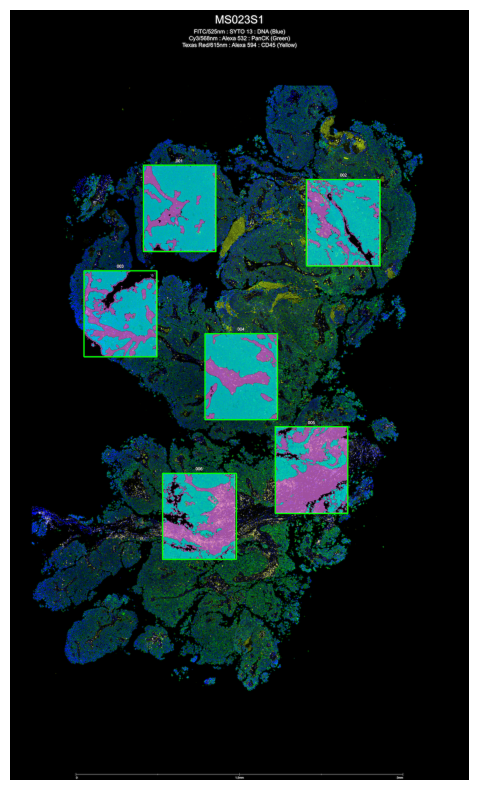

[(349, 1061, 518, 1258), (607, 954, 773, 1153), (446, 741, 612, 938), (169, 597, 336, 794), (678, 388, 847, 586), (305, 355, 471, 553)]


In [5]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def detect_rois(image_path, min_width=30, min_height=30, lower_white=np.array([100,100,100]), upper_white=np.array([255,255,255])):
    # Read the image
    image = cv2.imread(image_path)
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # Create a mask for white color
    mask = cv2.inRange(image, lower_white, upper_white)

    # Find contours
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    roi_boxes = []
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)

        # Check for minimum size
        if w >= min_width and h >= min_height:
            epsilon = 0.05 * cv2.arcLength(contour, True)
            approx = cv2.approxPolyDP(contour, epsilon, True)

            # Check if the contour is rectangular (has 4 vertices)
            if len(approx) == 4:
                roi_boxes.append((x, y, x+w, y+h))
                # Draw a bounding box around the detected ROI
                cv2.rectangle(image, (x, y), (x+w, y+h), (0, 255, 0), 2)
                # Print the width and height of the ROI
                print(f"ROI at ({x}, {y}): Width = {w}, Height = {h}")
    # Convert BGR to RGB for Matplotlib
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Display the result using Matplotlib
    plt.figure(figsize=(10, 10))
    plt.imshow(image_rgb)
    plt.axis("off")
    plt.show()

    return roi_boxes

# Example usage
image_path = "/Users/yshokrollahi/Desktop/MD/Project3/dataset/IF/SET2/MS023S1_MU_re.png"
rois = detect_rois(image_path)
print(rois)


/Users/yshokrollahi/Desktop/MD/Project3/dataset/IF/SET2/MS018S1_MU.png
ROI at (10564, 20859): Width = 1649, Height = 1964
ROI at (8236, 19879): Width = 1656, Height = 1964
ROI at (10897, 18055): Width = 1659, Height = 1972
ROI at (7489, 16535): Width = 1652, Height = 1978
ROI at (12771, 16270): Width = 1660, Height = 1971
ROI at (10077, 15770): Width = 1671, Height = 1971


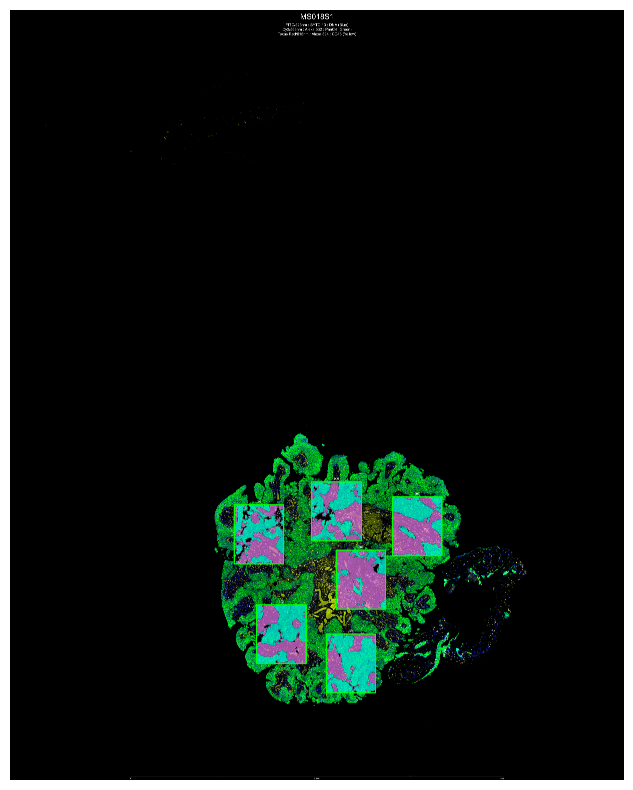

[(10564, 20859, 12213, 22823), (8236, 19879, 9892, 21843), (10897, 18055, 12556, 20027), (7489, 16535, 9141, 18513), (12771, 16270, 14431, 18241), (10077, 15770, 11748, 17741)]


In [8]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os


image_number = 18
SET = 2
image_name = f'MS0{image_number}S1'

def detect_rois_and_crop_from_another_image(first_image_path, second_image_path, output_folder, min_width=300, min_height=300, lower_white=np.array([100,100,100]), upper_white=np.array([255,255,255])):
    # Read the first image
    image = cv2.imread(first_image_path)
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # Create a mask for white color
    mask = cv2.inRange(image, lower_white, upper_white)

    # Find contours
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Load the second image for cropping
    crop_image = cv2.imread(second_image_path)

    roi_boxes = []
    for i, contour in enumerate(contours):
        x, y, w, h = cv2.boundingRect(contour)

        # Check for minimum size
        if w >= min_width and h >= min_height:
            epsilon = 0.05 * cv2.arcLength(contour, True)
            approx = cv2.approxPolyDP(contour, epsilon, True)

            # Check if the contour is rectangular (has 4 vertices)
            if len(approx) == 4:
                roi_boxes.append((x, y, x+w, y+h))
                # Draw a bounding box around the detected ROI on the first image
                cv2.rectangle(image, (x, y), (x+w, y+h), (0, 255, 0), 40)

                # Crop the ROI from the second image using the same coordinates
                roi = crop_image[y:y+h, x:x+w]
                # Save the cropped ROI
                cv2.imwrite(os.path.join(output_folder, f"{image_number}_roi_{i}.jpg"), roi)
                print(f"ROI at ({x}, {y}): Width = {w}, Height = {h}")
                
    # Convert BGR to RGB for Matplotlib
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Display the result using Matplotlib
    plt.figure(figsize=(10, 10))
    plt.imshow(image_rgb)
    plt.axis("off")
    plt.show()

    return roi_boxes

# Example usage
first_image_path = f"/Users/yshokrollahi/Desktop/MD/Project3/dataset/IF/SET{SET}/{image_name}_MU.png"
second_image_path = f"/Users/yshokrollahi/Desktop/MD/Project3/dataset/IF/SET{SET}/{image_name}.png"
output_folder = "/Users/yshokrollahi/Desktop/MD/Project3/dataset/IF/ROIs"
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

rois = detect_rois_and_crop_from_another_image(first_image_path, second_image_path, output_folder)
print(rois)
